# Analysis of Config Results

In [2]:
import os
import json
from scoring_pipeline import ScoringPipeline
import pandas as pd
from tqdm import tqdm

def load_config(config_file):
    with open(config_file, 'r') as f:
        return json.load(f)

def get_bit_size(config):
    if config and 'num_bits' in config[0]:
        return config[0]['num_bits']
    return None

def get_layer_type(config):
    if config and 'layer_type' in config[0]:
        return config[0]['layer_type']
    return None

def get_quantized_parts(config):
    parts = {
        'VIT': {'FIRST': 0, 'MIDDLE': 0, 'LAST': 0},
        'QFORMER': {'FIRST': 0, 'MIDDLE': 0, 'LAST': 0},
        'LLM': {'FIRST': 0, 'MIDDLE': 0, 'LAST': 0}
    }
    for item in config:
        if 'model_part' in item and 'layer_group' in item:
            if item['layer_group'] == 'ALL':
                parts[item['model_part']] = {'FIRST': 1, 'MIDDLE': 1, 'LAST': 1}
            else:
                parts[item['model_part']][item['layer_group']] = 1
    return parts

results = []
scorer = ScoringPipeline()

## Run Scoring Pipeline

In [ ]:
# Get list of files and use tqdm for progress bar
result_files = [f for f in os.listdir('./results') if f.endswith('.json')]
for filename in tqdm(result_files, desc="Processing files"):
    config_number = filename.split('.')[0]
    
    # Load and process config
    config_file = os.path.join('./configs', filename)
    config = load_config(config_file)
    bit_size = get_bit_size(config)
    layer_type = get_layer_type(config)
    quantized_parts = get_quantized_parts(config)

    # Load and process results
    result_file = os.path.join('./results', filename)
    loaded_results = scorer.load_results(result_file)
    scores = scorer.compute_scores(loaded_results, task='image_captioning')

    # Compile row data
    row = {
        'config': config_number,
        'bit_size': bit_size,
        'type': layer_type,
        'VIT_FIRST': quantized_parts['VIT']['FIRST'],
        'VIT_MIDDLE': quantized_parts['VIT']['MIDDLE'],
        'VIT_LAST': quantized_parts['VIT']['LAST'],
        'QFORMER_FIRST': quantized_parts['QFORMER']['FIRST'],
        'QFORMER_MIDDLE': quantized_parts['QFORMER']['MIDDLE'],
        'QFORMER_LAST': quantized_parts['QFORMER']['LAST'],
        'LLM_FIRST': quantized_parts['LLM']['FIRST'],
        'LLM_MIDDLE': quantized_parts['LLM']['MIDDLE'],
        'LLM_LAST': quantized_parts['LLM']['LAST'],
    }

    # Add metrics
    for metric, score in scores.items():
        if not metric.endswith('_per_caption'):
            row[metric] = score

    results.append(row)

# Create DataFrame and save to CSV
df = pd.DataFrame(results)
df.to_csv('quantization_results.csv', index=False)
print("Results saved to quantization_results.csv")

In [4]:
df = pd.DataFrame(results)

In [ ]:
df

## Plot Scores and Normalized Scores (Sorted by CIDEr)

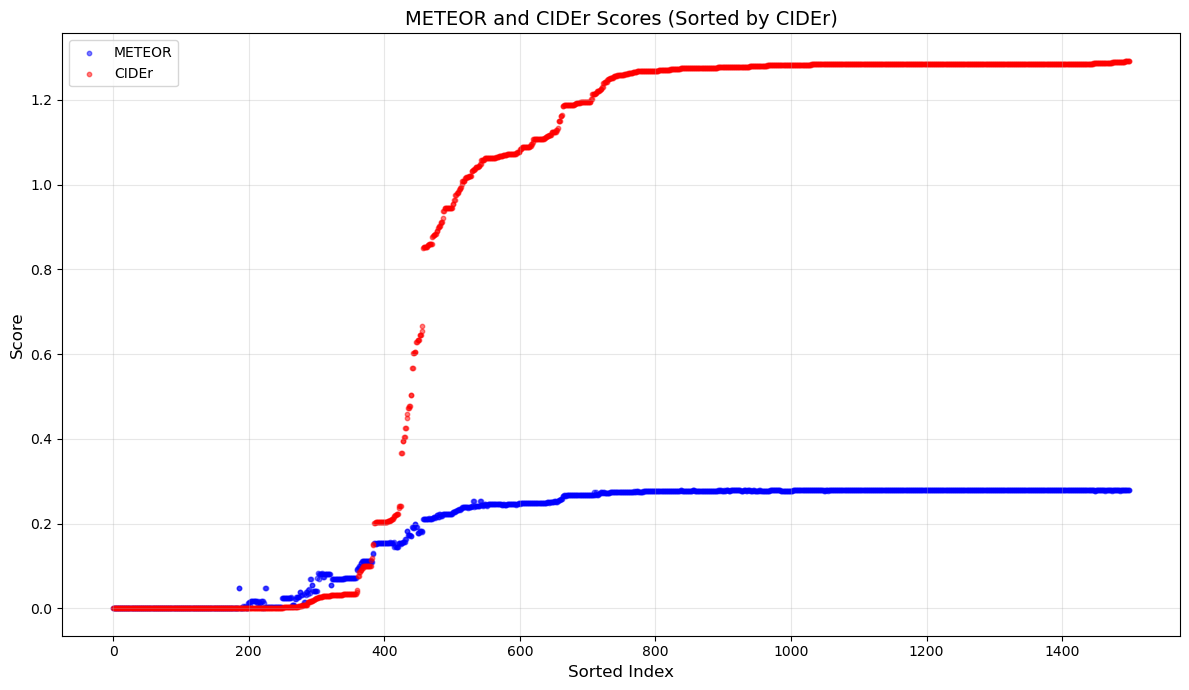

In [8]:
import matplotlib.pyplot as plt

# Assuming you have your data in a DataFrame called 'df'
df_sorted = df.sort_values('CIDEr').reset_index(drop=True)

plt.figure(figsize=(12, 7))

plt.scatter(df_sorted.index, df_sorted['METEOR'], color='blue', alpha=0.5, s=10, label='METEOR')
plt.scatter(df_sorted.index, df_sorted['CIDEr'], color='red', alpha=0.5, s=10, label='CIDEr')

plt.xlabel('Sorted Index', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('METEOR and CIDEr Scores (Sorted by CIDEr)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

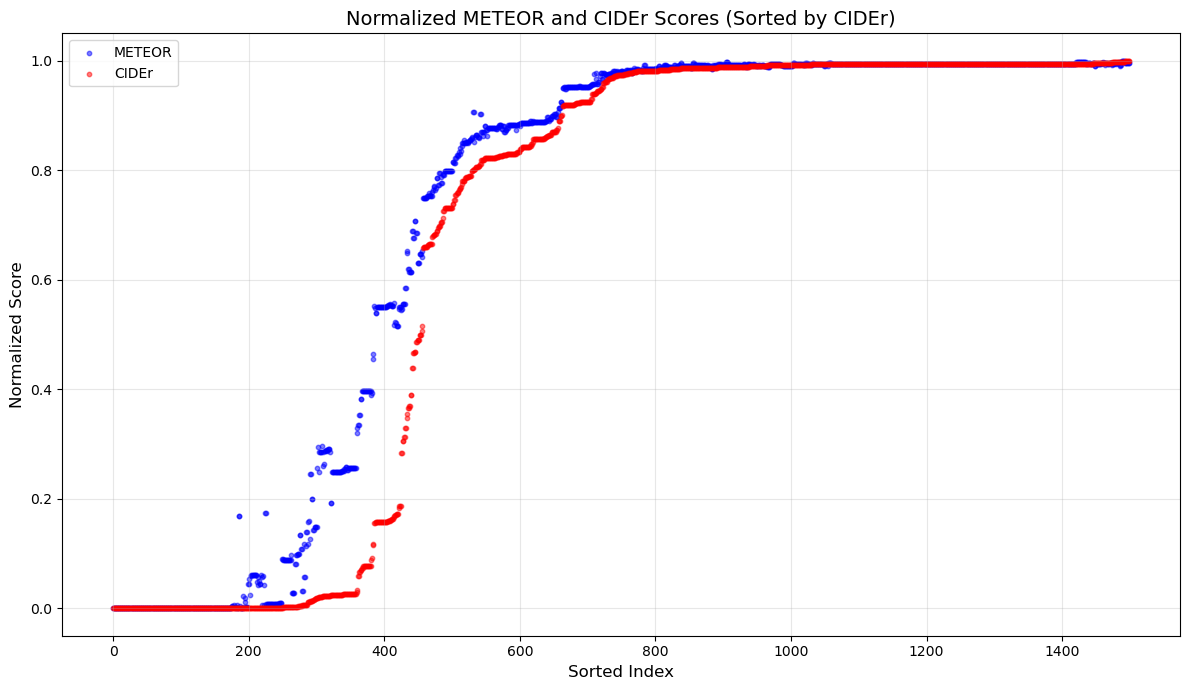

In [10]:
# Simple min-max normalization function
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Normalize the data
df_normalized = pd.DataFrame({
    'METEOR': normalize(df_sorted['METEOR']),
    'CIDEr': normalize(df_sorted['CIDEr'])
})

plt.figure(figsize=(12, 7))

plt.scatter(df_normalized.index, df_normalized['METEOR'], color='blue', alpha=0.5, s=10, label='METEOR')
plt.scatter(df_normalized.index, df_normalized['CIDEr'], color='red', alpha=0.5, s=10, label='CIDEr')

plt.xlabel('Sorted Index', fontsize=12)
plt.ylabel('Normalized Score', fontsize=12)
plt.title('Normalized METEOR and CIDEr Scores (Sorted by CIDEr)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Add Column for Measured Model Size

In [1]:
import pandas as pd

df = pd.read_csv('quantization_results.csv')

In [ ]:
import torch
from transformers import Blip2ForConditionalGeneration
from tqdm import tqdm

model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b")

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Usage:
total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params}")

In [3]:
def calculate_quantized_size(model, bit_size, layer_type, vit_first, vit_middle, vit_last, 
                             qformer_first, qformer_middle, qformer_last, 
                             llm_first, llm_middle, llm_last):
    
    def count_layer_params(layer, count_attention, count_mlp):
        param_count = 0
        if count_attention:
            if hasattr(layer, 'self_attn'):
                param_count += sum(p.numel() for p in layer.self_attn.parameters() if p.requires_grad)
            elif hasattr(layer, 'attention'):
                param_count += sum(p.numel() for p in layer.attention.parameters() if p.requires_grad)
        if count_mlp:
            if hasattr(layer, 'mlp'):
                param_count += sum(p.numel() for p in layer.mlp.parameters() if p.requires_grad)
            elif hasattr(layer, 'fc1') and hasattr(layer, 'fc2'):
                param_count += sum(p.numel() for p in layer.fc1.parameters() if p.requires_grad)
                param_count += sum(p.numel() for p in layer.fc2.parameters() if p.requires_grad)
        return param_count

    def quantize_part(layers, first, middle, last):
        total_layers = len(layers)
        first_end = total_layers // 3
        middle_start = first_end
        middle_end = 2 * total_layers // 3
        last_start = middle_end

        quantized_params = 0
        for i, layer in enumerate(layers):
            if (i < first_end and first) or \
               (middle_start <= i < middle_end and middle) or \
               (i >= last_start and last):
                quantized_params += count_layer_params(layer, 
                                                       layer_type in ['BOTH', 'ATTENTION'],
                                                       layer_type in ['BOTH', 'MLP'])
        return quantized_params

    vit_params = quantize_part(model.vision_model.encoder.layers, vit_first, vit_middle, vit_last)
    qformer_params = quantize_part(model.qformer.encoder.layer, qformer_first, qformer_middle, qformer_last)
    llm_params = quantize_part(model.language_model.model.decoder.layers, llm_first, llm_middle, llm_last)

    total_quantized_params = vit_params + qformer_params + llm_params
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Calculate the new model size
    original_size = total_params * 32  # Assuming original is 32-bit
    quantized_size = (total_params - total_quantized_params) * 32 + total_quantized_params * bit_size

    return quantized_size

## Sanity Checks

In [4]:
full_size = count_parameters(model) * 32
print(f"Full size: {full_size}")

for layer_type in ['BOTH', 'ATTENTION', 'MLP']:
    print(f"\nTesting with layer_type: {layer_type}")
    
    half_size = calculate_quantized_size(model, 16, layer_type, 1, 1, 1, 1, 1, 1, 1, 1, 1)
    print(f"Calculated half size: {half_size}")
    print(f"Ratio of size between full: {half_size/full_size}")

    quarter = calculate_quantized_size(model, 8, layer_type, 1, 1, 1, 1, 1, 1, 1, 1, 1)
    print(f"Calculated quarter size: {quarter}")
    print(f"Ratio of size between full: {quarter/full_size}")

    eight = calculate_quantized_size(model, 4, layer_type, 1, 1, 1, 1, 1, 1, 1, 1, 1)
    print(f"Calculated eight size: {eight}")
    print(f"Ratio of size between full: {eight/full_size}")

Full size: 119829757952

Testing with layer_type: BOTH
Calculated half size: 63346178048
Ratio of size between full: 0.5286347826336633
Calculated quarter size: 35104388096
Ratio of size between full: 0.2929521739504949
Calculated eight size: 20983493120
Ratio of size between full: 0.17511086960891067

Testing with layer_type: ATTENTION
Calculated half size: 100997128192
Ratio of size between full: 0.8428384561408881
Calculated quarter size: 91580813312
Ratio of size between full: 0.7642576842113323
Calculated eight size: 86872655872
Ratio of size between full: 0.7249672982465544

Testing with layer_type: MLP
Calculated half size: 82178807808
Ratio of size between full: 0.6857963264927751
Calculated quarter size: 63353332736
Ratio of size between full: 0.5286944897391626
Calculated eight size: 53940595200
Ratio of size between full: 0.45014357136235633


In [5]:
def apply_quantization(row, model):
    return calculate_quantized_size(
        model,
        row['bit_size'],
        row['type'],
        row['VIT_FIRST'],
        row['VIT_MIDDLE'],
        row['VIT_LAST'],
        row['QFORMER_FIRST'],
        row['QFORMER_MIDDLE'],
        row['QFORMER_LAST'],
        row['LLM_FIRST'],
        row['LLM_MIDDLE'],
        row['LLM_LAST']
    )

# Assuming your DataFrame is called 'df' and your model is called 'model'
df['quantized_size'] = df.apply(lambda row: apply_quantization(row, model), axis=1)

# Calculate the compression ratio
total_params = count_parameters(model)
original_size = total_params * 32
df['compression_ratio'] = df['quantized_size'] / original_size


In [ ]:
df

In [7]:
df.to_csv('quantization_results_w_size.csv', index=False)

In [ ]:
set(df['bit_size'])

In [13]:
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

# Define the discrete color map using a sequential colormap
bit_sizes = set(df['bit_size'])
n_colors = len(bit_sizes)
colors = px.colors.sequential.Plasma
color_indices = np.linspace(0, len(colors) - 1, n_colors).astype(int)
discrete_colors = [colors[i] for i in color_indices]
color_map = dict(zip(bit_sizes, discrete_colors))

# Rest of your plotting code remains the same
hover_text = df.apply(lambda row: '<br>'.join([
    f"{col}: {row[col]}" for col in df.columns
]), axis=1)

fig = go.Figure(data=[go.Scatter3d(
    x=df['METEOR'],
    y=df['CIDEr'],
    z=df['quantized_size'],
    mode='markers',
    marker=dict(
        size=5,
        color=[color_map[size] for size in df['bit_size']],
        opacity=0.8
    ),
    text=hover_text,
    hoverinfo='text'
)])

# Add discrete color legend
for bit_size, color in color_map.items():
    fig.add_trace(go.Scatter3d(
        x=[None], y=[None], z=[None],
        mode='markers',
        marker=dict(size=10, color=color),
        showlegend=True,
        name=f'{bit_size}-bit'
    ))

fig.update_layout(
    title='3D Scatter Plot of METEOR, CIDEr, and Quantized Size',
    scene=dict(
        xaxis_title='METEOR',
        yaxis_title='CIDEr',
        zaxis_title='Quantized Size'
    ),
    width=800,
    height=800,
    margin=dict(r=20, b=10, l=10, t=40),
    legend_title='Bit Size'
)

fig.write_html("3d_plot.html")

## QFormer Bug

In [ ]:
df[df["compression_ratio"]>=1]

In [50]:
def calculate_quantized_size(model, bit_size, layer_type, vit_first, vit_middle, vit_last, 
                             qformer_first, qformer_middle, qformer_last, 
                             llm_first, llm_middle, llm_last):
    
    def count_layer_params(layer, count_attention, count_mlp):
        param_count = 0
        if count_attention:
            if hasattr(layer, 'self_attn'):
                param_count += sum(p.numel() for p in layer.self_attn.parameters() if p.requires_grad)
            elif hasattr(layer, 'attention'):
                param_count += sum(p.numel() for p in layer.attention.parameters() if p.requires_grad)
        if count_mlp:
            if hasattr(layer, 'mlp'):
                param_count += sum(p.numel() for p in layer.mlp.parameters() if p.requires_grad)
            elif hasattr(layer, 'fc1') and hasattr(layer, 'fc2'):
                param_count += sum(p.numel() for p in layer.fc1.parameters() if p.requires_grad)
                param_count += sum(p.numel() for p in layer.fc2.parameters() if p.requires_grad)
        return param_count

    def quantize_part(layers, first, middle, last):
        total_layers = len(layers)
        first_end = total_layers // 3
        middle_start = first_end
        middle_end = 2 * total_layers // 3
        last_start = middle_end

        quantized_params = 0
        for i, layer in enumerate(layers):
            if (i < first_end and first) or \
               (middle_start <= i < middle_end and middle) or \
               (i >= last_start and last):
                quantized_params += count_layer_params(layer, 
                                                       layer_type in ['BOTH', 'ATTENTION'],
                                                       layer_type in ['BOTH', 'MLP'])
        return quantized_params

    vit_params = quantize_part(model.vision_model.encoder.layers, vit_first, vit_middle, vit_last)
    qformer_params = quantize_part(model.qformer.encoder.layer, qformer_first, qformer_middle, qformer_last)
    llm_params = quantize_part(model.language_model.model.decoder.layers, llm_first, llm_middle, llm_last)

    print(f"VIT params quantized: {vit_params}")
    print(f"QFormer params quantized: {qformer_params}")
    print(f"LLM params quantized: {llm_params}")

    total_quantized_params = vit_params + qformer_params + llm_params
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total params: {total_params}")
    print(f"Total quantized params: {total_quantized_params}")

    # Calculate the new model size
    original_size = total_params * 32  # Assuming original is 32-bit
    quantized_size = (total_params - total_quantized_params) * 32 + total_quantized_params * bit_size

    return quantized_size

In [ ]:
import torch
from torch import nn

# Assuming you have your BLIP-2 model loaded as 'model'

def test_qformer_structure():
    print("QFormer Structure:")
    print(model.qformer)
    print("\nNumber of QFormer layers:", len(model.qformer.encoder.layer))

def count_qformer_params():
    return sum(p.numel() for p in model.qformer.parameters() if p.requires_grad)

def test_qformer_param_count():
    qformer_params = count_qformer_params()
    print(f"Total QFormer parameters: {qformer_params}")

def test_qformer_layer_param_count():
    for i, layer in enumerate(model.qformer.encoder.layer):
        layer_params = sum(p.numel() for p in layer.parameters() if p.requires_grad)
        print(f"QFormer Layer {i} parameters: {layer_params}")

def test_qformer_quantization(bit_size, layer_type, first, middle, last):
    def count_layer_params(layer, count_attention, count_mlp):
        param_count = 0
        if count_attention:
            if hasattr(layer, 'self_attn'):
                param_count += sum(p.numel() for p in layer.self_attn.parameters() if p.requires_grad)
            elif hasattr(layer, 'attention'):
                param_count += sum(p.numel() for p in layer.attention.parameters() if p.requires_grad)
        if count_mlp:
            if hasattr(layer, 'mlp'):
                param_count += sum(p.numel() for p in layer.mlp.parameters() if p.requires_grad)
            elif hasattr(layer, 'fc1') and hasattr(layer, 'fc2'):
                param_count += sum(p.numel() for p in layer.fc1.parameters() if p.requires_grad)
                param_count += sum(p.numel() for p in layer.fc2.parameters() if p.requires_grad)
        return param_count

    layers = model.qformer.encoder.layer
    total_layers = len(layers)
    first_end = total_layers // 3
    middle_start = first_end
    middle_end = 2 * total_layers // 3
    last_start = middle_end

    quantized_params = 0
    for i, layer in enumerate(layers):
        if (i < first_end and first) or \
           (middle_start <= i < middle_end and middle) or \
           (i >= last_start and last):
            layer_params = count_layer_params(layer, 
                                              layer_type in ['BOTH', 'ATTENTION'],
                                              layer_type in ['BOTH', 'MLP'])
            quantized_params += layer_params
            print(f"Layer {i} quantized parameters: {layer_params}")

    print(f"Total QFormer quantized parameters: {quantized_params}")
    total_params = count_qformer_params()
    print(f"QFormer compression ratio: {quantized_params * bit_size / (total_params * 32):.4f}")

# Run the tests
print("Test 1: QFormer Structure")
test_qformer_structure()

print("\nTest 2: QFormer Parameter Count")
test_qformer_param_count()

print("\nTest 3: QFormer Layer-wise Parameter Count")
test_qformer_layer_param_count()

print("\nTest 4: QFormer Quantization (8-bit, MLP, all layers)")
test_qformer_quantization(8, 'MLP', True, True, True)

print("\nTest 5: QFormer Quantization (4-bit, ATTENTION, first third)")
test_qformer_quantization(4, 'ATTENTION', True, False, False)

print("\nTest 6: QFormer Quantization (16-bit, BOTH, middle third)")
test_qformer_quantization(16, 'BOTH', False, True, False)

In [ ]:
def count_mlp_layers(model, model_name):
    mlp_count = 0
    for name, module in model.named_modules():
        if 'mlp' in name.lower() or 'mlp' in name.lower() or ('intermediate' in name.lower() and 'dense' in name.lower()):
            mlp_count += 1
    print(f"Number of MLP layers in {model_name}: {mlp_count}")

# Count MLP layers in the vision model
count_mlp_layers(model.vision_model, "Vision Model")

# Count MLP layers in the language model
count_mlp_layers(model.language_model, "Language Model")

In [61]:
def count_mlp_layers(model, model_name):
    mlp_count = 0
    for name, module in model.named_modules():
        if 'fc1' in name.lower() or 'fc1' in name.lower() or ('intermediate' in name.lower() and 'dense' in name.lower()):
            mlp_count += 1
        elif 'fc2' in name.lower() or 'fc2' in name.lower() or ('intermediate' in name.lower() and 'dense' in name.lower()):
            mlp_count += 1
    print(f"Number of FC1 layers in {model_name}: {mlp_count}")

# Count MLP layers in the vision model
count_mlp_layers(model.vision_model, "Vision Model")

# Count MLP layers in the language model
count_mlp_layers(model.language_model, "Language Model")

Number of FC1 layers in Vision Model: 78
Number of FC1 layers in Language Model: 64


In [ ]:
model.language_model

In [ ]:
model.vision_model